In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
import seaborn as sns
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor

In [27]:
def print_corr(correlation_matrix):
    # Criando o correlograma com seaborn
    plt.figure(figsize=(8, 6))  # Define o tamanho do gráfico
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlograma das Variáveis")
    plt.show()

In [28]:
#carrega as bases de dados
df = pd.read_csv("./data/Features_data_set.csv", delimiter=';', decimal=',')
df_sales = pd.read_csv("./data/sales_data_set.csv", delimiter=';', decimal=',')

df_sales_s = df_sales.groupby(['Date','Store'])['Weekly_Sales'].sum().reset_index()

df =  pd.merge(df, df_sales_s, on=['Date','Store'], how='left')
print(df.shape)
df.head()

(8190, 13)


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Weekly_Sales
0,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,1643690.90
1,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,1641957.44
2,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,1611968.17
3,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,1409727.59
4,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,1554806.68


In [29]:
#filtra somente 
df = df[df['Date'] > '10/11/2011']
df = df[df['IsHoliday'] == True]
df.fillna(0, inplace=True)

In [30]:
# Filtrar os dados relevantes para a análise
#df_model = df[['Date','Weekly_Sales', 'Discounts','IsHoliday', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']]
df_model = df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5','Date','Weekly_Sales']]

In [31]:
# Criação variaveis dummy com os meses 
df_model['Date'] = pd.to_datetime(df_model['Date'], format='%d/%m/%Y')

df_model['Month'] = df_model['Date'].dt.month

month_dummies = pd.get_dummies(df_model['Month'], prefix='Month')

df_model = pd.concat([df_model, month_dummies], axis=1)

df_model.drop(columns=['Month'], inplace=True)

df_model.head()


C:\Users\Thbue\AppData\Local\Temp\ipykernel_23572\3597275000.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['Date'] = pd.to_datetime(df_model['Date'], format='%d/%m/%Y')
C:\Users\Thbue\AppData\Local\Temp\ipykernel_23572\3597275000.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['Month'] = df_model['Date'].dt.month


,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Date,Weekly_Sales,Month_2,Month_11,Month_12
1,0.00,0.0,0.00,0.0,0.00,2010-02-12,1641957.44,True,False,False
42,0.00,0.0,0.00,0.0,0.00,2010-11-26,1955624.11,False,True,False
47,0.00,0.0,0.00,0.0,0.00,2010-12-31,1367320.01,False,False,True
53,0.00,0.0,0.00,0.0,0.00,2011-02-11,1649614.93,True,False,False
94,410.31,98.0,55805.51,8.0,554.92,2011-11-25,2033320.66,False,True,False


In [32]:
#criação das variáveis lag
df_model = df_model.sort_values('Date')

# Criar variáveis de lag para as colunas de descontos (MarkDown1, MarkDown2, ..., MarkDown5)
lags = [1, 2, 3]  # Exemplo de lags de 1, 2 e 3 períodos

for lag in lags:
    for col in ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']:
        df_model[f'{col}_lag{lag}'] = df_model[col].shift(lag)

#Criar variáveis de lag para a coluna 'Weekly_Sales', se necessário
for lag in lags:
    df_model[f'Weekly_Sales_lag{lag}'] = df_model['Weekly_Sales'].shift(lag)

# Mostrar o dataframe com as novas colunas de lag
df_model.fillna(0, inplace=True)
df_model.head()

,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Date,Weekly_Sales,Month_2,Month_11,Month_12,...,MarkDown4_lag2,MarkDown5_lag2,MarkDown1_lag3,MarkDown2_lag3,MarkDown3_lag3,MarkDown4_lag3,MarkDown5_lag3,Weekly_Sales_lag1,Weekly_Sales_lag2,Weekly_Sales_lag3
1,0.0,0.0,0.0,0.0,0.0,2010-02-12,1641957.44,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00
5643,0.0,0.0,0.0,0.0,0.0,2010-02-12,1123566.12,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1641957.44,0.00,0.00
2003,0.0,0.0,0.0,0.0,0.0,2010-02-12,1117863.33,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1123566.12,1641957.44,0.00
5825,0.0,0.0,0.0,0.0,0.0,2010-02-12,294882.83,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1117863.33,1123566.12,1641957.44
1821,0.0,0.0,0.0,0.0,0.0,2010-02-12,1574684.08,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,294882.83,1117863.33,1123566.12


In [33]:
#tratamento de dados para a entrada na regressão
colunas = df_model.drop(columns=['Weekly_Sales', 'Date']).columns.tolist()  
df_var_indep = df_model[colunas].copy()

# Converte para numérico e trata booleanos explicitamente
for col in df_var_indep.columns:
    if df_var_indep[col].dtype == bool:
        df_var_indep[col] = df_var_indep[col].astype(int)  # Converte booleans para inteiros
    else:
        df_var_indep[col] = pd.to_numeric(df_var_indep[col], errors='coerce')

df_var_indep.head()
print(df_var_indep.dtypes)

MarkDown1            float64
MarkDown2            float64
MarkDown3            float64
MarkDown4            float64
MarkDown5            float64
Month_2                int32
Month_11               int32
Month_12               int32
MarkDown1_lag1       float64
MarkDown2_lag1       float64
MarkDown3_lag1       float64
MarkDown4_lag1       float64
MarkDown5_lag1       float64
MarkDown1_lag2       float64
MarkDown2_lag2       float64
MarkDown3_lag2       float64
MarkDown4_lag2       float64
MarkDown5_lag2       float64
MarkDown1_lag3       float64
MarkDown2_lag3       float64
MarkDown3_lag3       float64
MarkDown4_lag3       float64
MarkDown5_lag3       float64
Weekly_Sales_lag1    float64
Weekly_Sales_lag2    float64
Weekly_Sales_lag3    float64
dtype: object


In [36]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(df_var_indep, df_model['Weekly_Sales'])

# Obter a importância das variáveis
feature_importances = rf.feature_importances_
sorted_idx = feature_importances.argsort()

# Exibir variáveis mais importantes
print("Importância das variáveis:", sorted_idx)
print(df_var_indep.columns[sorted_idx].tolist())

Importância das variáveis: [15 16 20 14  9 19 21 13 18 22 10 17 11  3  4  7  8  5 12  0  1  6 25  2
 24 23]
['MarkDown3_lag2', 'MarkDown4_lag2', 'MarkDown3_lag3', 'MarkDown2_lag2', 'MarkDown2_lag1', 'MarkDown2_lag3', 'MarkDown4_lag3', 'MarkDown1_lag2', 'MarkDown1_lag3', 'MarkDown5_lag3', 'MarkDown3_lag1', 'MarkDown5_lag2', 'MarkDown4_lag1', 'MarkDown4', 'MarkDown5', 'Month_12', 'MarkDown1_lag1', 'Month_2', 'MarkDown5_lag1', 'MarkDown1', 'MarkDown2', 'Month_11', 'Weekly_Sales_lag3', 'MarkDown3', 'Weekly_Sales_lag2', 'Weekly_Sales_lag1']


In [38]:
#seleção variáveis de entrada 
features = df_var_indep[df_var_indep.columns[sorted_idx].tolist()]
features = df_var_indep.drop(columns=['Month_11','MarkDown3_lag2','MarkDown2_lag1','MarkDown5_lag1','MarkDown4_lag2','Month_2','MarkDown5_lag3','MarkDown1_lag3','MarkDown5_lag2','MarkDown2_lag2','MarkDown4','MarkDown4_lag1','MarkDown1_lag1','Month_12','MarkDown4_lag3','MarkDown1_lag2']).columns.tolist()  

In [39]:
# Adicionar uma constante para a regressão (intercepto)
X = sm.add_constant(df_var_indep[features])
y = df_model['Weekly_Sales']

# Ajustar o modelo de regressão linear
model = sm.OLS(y, X)
results = model.fit()

# Exibir o resumo dos resultados
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           Weekly_Sales   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     29.01
Date:                Mon, 02 Dec 2024   Prob (F-statistic):           2.56e-40
Time:                        19:05:00   Log-Likelihood:                -5280.4
No. Observations:                 360   AIC:                         1.058e+04
Df Residuals:                     349   BIC:                         1.063e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              3.814e+05   7.37e+0

In [40]:
# Exportar o resumo para um arquivo HTML
with open('resumo_OLS.html', 'w') as f:
    f.write(results.summary().as_html())

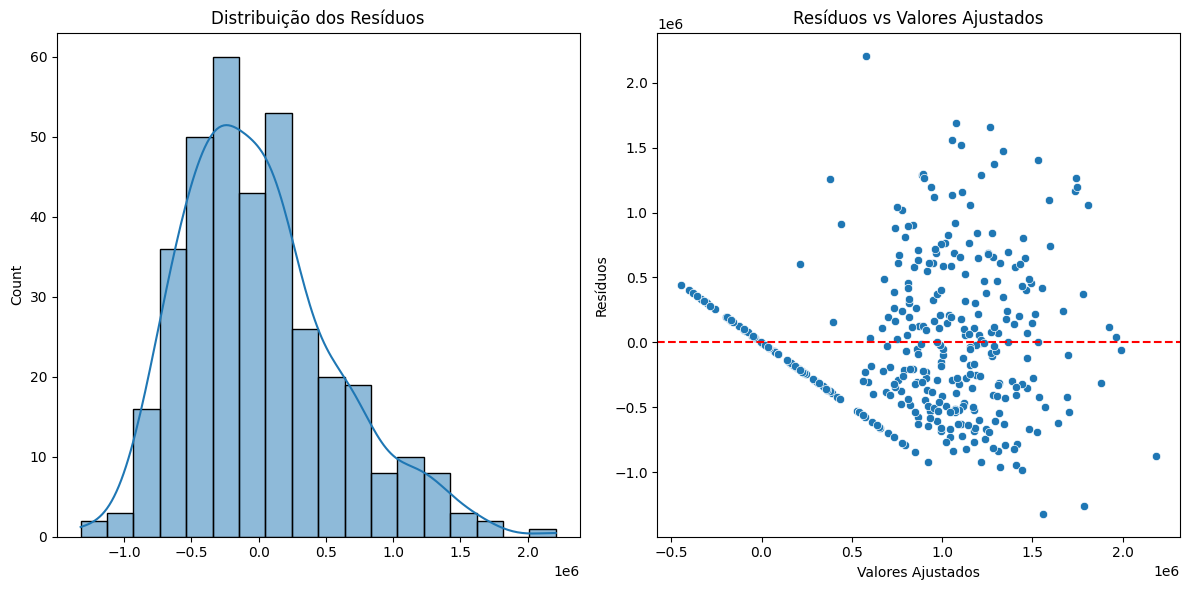


VIF para cada variável:
             Variable       VIF
0               const  5.882570
1           MarkDown1  2.639078
2           MarkDown2  2.488831
3           MarkDown3  2.362276
4           MarkDown5  1.804418
5      MarkDown3_lag1  2.193105
6      MarkDown2_lag3  1.400905
7      MarkDown3_lag3  2.052642
8   Weekly_Sales_lag1  1.588983
9   Weekly_Sales_lag2  1.582292
10  Weekly_Sales_lag3  1.593798


In [41]:
# --- Análise de resíduos ---
# Calcular resíduos
residuals = results.resid

# Plotando a distribuição dos resíduos
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('Distribuição dos Resíduos')

# Gráfico de resíduos vs valores ajustados
plt.subplot(1, 2, 2)
sns.scatterplot(x=results.fittedvalues, y=residuals)
plt.axhline(0, linestyle='--', color='red')
plt.title('Resíduos vs Valores Ajustados')
plt.xlabel('Valores Ajustados')
plt.ylabel('Resíduos')

plt.tight_layout()
plt.show()

# --- Análise de Colinearidade ---
# Calculando o VIF (Variance Inflation Factor)
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Exibir o VIF para cada variável
print("\nVIF para cada variável:")
print(vif_data)

